### Imports

In [668]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, roc_auc_score
import recordlinkage as rl
from numpy.random import choice
from sklearn.utils import shuffle
import collections
from recordlinkage.preprocessing import phonetic
from recordlinkage.index import Block

# Models to use
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

### Load the patient record dataset

In [669]:
#filename = 'Custom'
#filename = 'febrl4_UNSW'
#filename = 'ePBRN_F_dup'
filename = 'febrl3_UNSW_rep'
data = pd.read_csv(f"../test/{filename}.csv")
random_seed = 42

In [670]:
# Test that this makes a copy of the data
# test1 = data
# test2 = data

# test1 = pd.concat([test1, test1.loc[[0]]], ignore_index=True)

# print(len(test1))
# print(len(test2))
# # print(test1.iloc[0]['rec_id'])
# # print(test2.iloc[0]['rec_id'])

### Clean up record IDs

In [671]:
# Cleanup records
data['rec_id'] = data['rec_id'].str.replace("rec-", "")
data['rec_id'] = data['rec_id'].str.replace("-org", "")

### Handle Missing Values and Clean Up

In [672]:
if ('date_of_birth' in data):
    data['date_of_birth']  = pd.to_datetime(data['date_of_birth'], errors = 'coerce')
    data['day'] = data['date_of_birth'].dt.strftime('%d')
    data['month'] = data['date_of_birth'].dt.strftime('%m')
    data['year'] = data['date_of_birth'].dt.strftime('%Y')

if ('postcode' in data):
    data['postcode'] = data['postcode'].astype(str)

## New
# Fill missing values for 'culture', 'sex', and 'state' with a default value
default_values = {'sex': 'unknown', 'state': 'unknown'}
data.fillna(value=default_values, inplace=True)

# Remove extra spaces from string columns
string_columns = ['given_name', 'surname', 'address_1', 'address_2']
for col in string_columns:
    data[col] = data[col].astype(str).str.strip().str.lower()

# Impute missing values for numerical columns with the mean value
if ('date_of_birth' in data):
    numerical_columns = ['date_of_birth', 'phone_number', 'national_identifier', 'blocking_number']
else:
    numerical_columns = ['postcode', 'street_number']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop the 'blocking_number' field
if ('date_of_birth' in data):
    data = data.drop(columns=['culture', 'date_of_birth', 'state'])
#data = data.drop(columns=['blocking_number', 'street_number', 'address_1', 'address_2', 'date_of_birth', 'culture', 'state'])

if ('sex' in data):
    for col in ["surname", "given_name", "address_1", "address_2", "sex"]:
        data[col] = data[col].fillna('unknown')
        data[col] = data[col].astype(str)
else:
    for col in ["surname", "given_name", "address_1", "address_2"]:
        data[col] = data[col].fillna('unknown')
        data[col] = data[col].astype(str)

### Deal with Duplicates

In [673]:
# Cleanup records
data['rec_id'] = data['rec_id'].str.replace("rec-", "")
data['rec_id'] = data['rec_id'].str.replace("-org", "")

if "match_id" not in data:
    # Identify known duplicates based on the rec_id column
    duplicates = data[data["rec_id"].str.contains("-dup-")]

    # Create a dictionary mapping each duplicate record to its corresponding original record
    originals = {}
    for i, row in duplicates.iterrows():
        original_id = row["rec_id"].replace("-dup-0", "")
        if original_id in originals:
            originals[original_id].append(i)
        else:
            originals[original_id] = [i]

    # Create a new column called "match" to indicate whether a record is a duplicate or not
    data["match_id"] = data["rec_id"]
    for original_id, duplicates in originals.items():
        data.loc[duplicates, "match_id"] = original_id
        # this ensures that both the duplicate and the match are in the same training set
        data.loc[data['rec_id'] == original_id, 'match_id'] = original_id

    data["match_id"] = data["match_id"].astype(int)

# get all fields
all_fields = data.columns.values.tolist()
print("All fields:", all_fields)

All fields: ['Unnamed: 0', 'rec_id', 'given_name', 'surname', 'street_number', 'address_1', 'address_2', 'suburb', 'postcode', 'state', 'day', 'month', 'year', 'match_id']


In [674]:
# Test true links
def generate_true_links(df): 
    # although the match_id column is included in the original df to imply the true links,
    # this function will create the true_link object identical to the true_links properties
    # of recordlinkage toolkit, in order to exploit "Compare.compute()" from that toolkit
    # in extract_function() for extracting features quicker.
    # This process should be deprecated in the future release of the UNSW toolkit.
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    processed = 0
    for match_id in df["match_id"].unique():
        if match_id != -1:    
            processed = processed + 1
            # print("In routine generate_true_links(), count =", processed)
            # clear_output(wait=True)
            linkages = df.loc[df['match_id'] == match_id]
            for j in range(len(linkages)-1):
                for k in range(j+1, len(linkages)):
                    indices_1 = indices_1 + [linkages.iloc[j]["rec_id"]]
                    indices_2 = indices_2 + [linkages.iloc[k]["rec_id"]]    
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def generate_false_links(df, size):
    # A counterpart of generate_true_links(), with the purpose to generate random false pairs
    # for training. The number of false pairs in specified as "size".
    df["rec_id"] = df.index.values.tolist()
    indices_1 = []
    indices_2 = []
    unique_match_id = df["match_id"].unique()
    unique_match_id = unique_match_id[~np.isnan(unique_match_id)] # remove nan values
    for j in range(size):
            false_pair_ids = choice(unique_match_id, 2)
            candidate_1_cluster = df.loc[df['match_id'] == false_pair_ids[0]]
            candidate_1 = candidate_1_cluster.iloc[choice(range(len(candidate_1_cluster)))]
            candidate_2_cluster = df.loc[df['match_id'] == false_pair_ids[1]]
            candidate_2 = candidate_2_cluster.iloc[choice(range(len(candidate_2_cluster)))]    
            indices_1 = indices_1 + [candidate_1["rec_id"]]
            indices_2 = indices_2 + [candidate_2["rec_id"]]  
    links = pd.MultiIndex.from_arrays([indices_1,indices_2])
    return links

def swap_fields_flag(f11, f12, f21, f22):
    return ((f11 == f22) & (f12 == f21)).astype(float)

def join_names_space(f11, f12, f21, f22):
    return ((f11+" "+f12 == f21) | (f11+" "+f12 == f22)| (f21+" "+f22 == f11)| (f21+" "+f22 == f12)).astype(float)

def join_names_dash(f11, f12, f21, f22):
    return ((f11+"-"+f12 == f21) | (f11+"-"+f12 == f22)| (f21+"-"+f22 == f11)| (f21+"-"+f22 == f12)).astype(float)

def abb_surname(f1, f2):
    return ((f1[0]==f2) | (f1==f2[0])).astype(float)

def reset_day(f11, f12, f21, f22):
    return (((f11 == 1) & (f12 == 1))|((f21 == 1) & (f22 == 1))).astype(float)

def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro', threshold=0.90)
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro', threshold=0.90)
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven', threshold=0.90)
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven', threshold=0.90)
    if ('postcode' in data):
        exact_fields = ['street_number', 'year', 'postcode', 'day', 'month', 'address_1', 'address_2']
    else:
        exact_fields = ['street_number', 'year', 'day', 'month', 'address_1', 'address_2']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.string('address_1', 'address_1', method='levenshtein', label='y_address_1_leven', threshold=0.75)
    c.string('address_2', 'address_2', method='levenshtein', label='y_address_2_leven', threshold=0.75)

    if ('national_identifier' in data):
        data['national_identifier'] = data['national_identifier'].astype(str)
    if ('phone_number' in data):
        data['phone_number'] = data['phone_number'].astype(str)
    if ('national_identifier' in data):
        c.string('national_identifier', 'national_identifier', label='y_national_identifier_num', missing_value="-1")
    if ('phone_number' in data):
        c.string('phone_number', 'phone_number', label='y_phone_number_num', missing_value="-1")

    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

# see example of true links
true_links_data = generate_true_links(data)
#print(true_links_data)

false_links_data = generate_false_links(data, len(true_links_data))
#print(false_links_data)

# get negative and positive features
pos = extract_features(data, true_links_data)
neg = extract_features(data, false_links_data)

### Encode data for machine learning

In [675]:
def generate_train_X_y():
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=random_seed)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = generate_train_X_y()

print('X_train\n')
print(len(X_train))

print('y_train\n')
print(len(y_train))

X_train

13076
y_train

13076


### Initialize machine learning models

In [676]:
def train_model(modeltype, modelparam, train_vectors, train_labels, modeltype_2):
    if modeltype == 'rf': # Random Forest
        if modelparam < 1:
            modelparam = 1
        model = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion=modeltype_2, max_depth=modelparam)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'xgboost': # Gradient Boosted Trees
        #model = GradientBoostingClassifier(n_estimators=100, random_state=random_seed, loss=modeltype_2, learning_rate=modelparam)
        model = XGBClassifier(n_estimators=100, seed=random_seed, max_depth=6, learning_rate=1, gamma=modelparam,  objective=modeltype_2)
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'sc': # StackingClassifier
        if modelparam < 2:
            modelparam = 2
        if modelparam > 1000:
            modelparam = 1000
            
        # Define the classifiers
        estimators = [
            ('rf', RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='gini', max_depth=1)),
            ('xgb', XGBClassifier(n_estimators=100, seed=random_seed, max_depth=6, learning_rate=1, gamma=10, objective='binary:hinge')),
            ('mlp', MLPClassifier(solver='lbfgs', alpha=2000, hidden_layer_sizes=(256, ), 
                              activation = 'relu',random_state=random_seed, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=30000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08))
        ]

        # Create the StackingClassifier
        model = StackingClassifier(
            estimators=estimators,
            final_estimator=LogisticRegression(C=0.001, penalty='l2', max_iter=5000, multi_class='ovr', random_state=random_seed),
            cv=modelparam,
            n_jobs=-1,
            stack_method=modeltype_2
        )
        model.fit(train_vectors, train_labels) 
    elif modeltype == 'lr': # Logistic Regression
        model = LogisticRegression(C=modelparam, penalty = modeltype_2,class_weight=None, dual=False, fit_intercept=True, 
                                   intercept_scaling=1, max_iter=5000, multi_class='ovr', 
                                   n_jobs=1, random_state=random_seed)
        model.fit(train_vectors, train_labels)
    elif modeltype == 'nn': # Neural Network
        model = MLPClassifier(solver='lbfgs', alpha=modelparam, hidden_layer_sizes=(256, ), 
                              activation = modeltype_2,random_state=random_seed, batch_size='auto', 
                              learning_rate='constant',  learning_rate_init=0.001, 
                              power_t=0.5, max_iter=30000, shuffle=True, 
                              tol=0.0001, verbose=False, warm_start=False, momentum=0.9, 
                              nesterovs_momentum=True, early_stopping=False, 
                              validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        model.fit(train_vectors, train_labels)
    return model

def classify(model, test_vectors):
    result = model.predict(test_vectors)
    return result

def set_to_zero_if_nan(value):
    if np.isnan(value):
        return 0
    return value

def evaluation(test_labels, result, model, X_test):
    true_pos = np.logical_and(test_labels, result)
    count_true_pos = np.sum(true_pos)
    true_neg = np.logical_and(np.logical_not(test_labels),np.logical_not(result))
    count_true_neg = np.sum(true_neg)
    false_pos = np.logical_and(np.logical_not(test_labels), result)
    count_false_pos = np.sum(false_pos)
    false_neg = np.logical_and(test_labels,np.logical_not(result))
    count_false_neg = np.sum(false_neg)

    precision = set_to_zero_if_nan(count_true_pos/(count_true_pos+count_false_pos))
    sensitivity = set_to_zero_if_nan(count_true_pos/(count_true_pos+count_false_neg)) # sensitivity = recall
    confusion_matrix = [count_true_pos, count_false_pos, count_false_neg, count_true_neg]
    no_links_found = np.count_nonzero(result)
    no_false = set_to_zero_if_nan(count_false_pos + count_false_neg)
    Fscore = set_to_zero_if_nan(2*precision*sensitivity/(precision+sensitivity))

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    a = accuracy_score(test_labels, result)
    c = confusion_matrix
    p = precision
    f = Fscore
    r = sensitivity
    auc =  roc_auc_score(test_labels, y_pred_proba)
    
    metrics_result = {
        'confusion_matrix': c,
        'precision': p,
        'F-score': f, 
        'accuracy_score': a,
        'recall_score': r,
        'sensitivity': sensitivity,
        'auc_score': auc,
        'no_false': no_false,
        'no_links':no_links_found
    }
    return metrics_result

In [677]:
def blocking_performance(candidates, true_links, df):
    count = 0
    for candi in candidates:
        if df.loc[candi[0]]["match_id"]==df.loc[candi[1]]["match_id"]:
            count = count + 1
    return count

# Blocking Criteria: declare non-match of all of the below fields disagree
# Import
print("Import test set...")
df_test = data

test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
number_of_records = len(df_test)
number_of_duplicates = leng_test_true_links
print("Test set size:", number_of_records, ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
if ('postcode' in data):
    blocking_fields = ["given_name", "surname", "postcode"]
else:
    blocking_fields = ["given_name", "surname", "phone_number"]
all_candidate_pairs = []
for field in blocking_fields:
    #block_indexer = rl.BlockIndex(on=field)
    indexer = rl.Index()
    #indexer.add(Block())
    indexer.block(on=field)
    #indexer.block(left_on=field, right_on=field)
    candidates = indexer.index(df_test)
    detects = blocking_performance(candidates, test_true_links, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )
detects = blocking_performance(all_candidate_pairs, test_true_links, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...
Test set size: 5000 , number of matched pairs:  6538
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 51865 , detected  3724 /6538 true matched pairs, missed 2814
Number of pairs of matched surname: 40336 , detected  3627 /6538 true matched pairs, missed 2911
Number of pairs of matched postcode: 16115 , detected  4989 /6538 true matched pairs, missed 1549
Number of pairs of at least 1 field matched: 101781 , detected  6114 /6538 true matched pairs, missed 424


In [678]:
print("Processing test set...")
print("Preprocess...")
#df_test['postcode'] = df_test['postcode'].astype(str)

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=random_seed)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 95667, 1: 6114})
Finished building X_test, y_test


In [679]:
# Comment out to perform grid search
# Choose model and hyperparameters
# We used grid search to find the best hyperparameter and a logarithmic scale to detrmine the best tuning value
# print("PERFORM GRID SEARCH ON SELECTED MODELS:")
# modeltype = 'sc' # choose between 'rf', 'xgboost', 'lr', 'sc', 'nn'
# modeltype_2 = 'predict'  # 'l2' or 'none' for lr, 'relu' or 'logistic' for nn, 'binary:logistic', 'binary:hinge', or 'binary:logitraw' for xgboost, 'gini', 'entropy', or 'log_loss' for rf, "auto", 'predict' for sc
# modelparam_range = [.001,.002,.005,.01,.02,.05,.1,.2,.5,1,5,10,20,50,100,200,500,1000,2000,5000] # C for svm, C for lg, alpha for NN
# print("Model:",modeltype,", Param_1:",modeltype_2, ", tuning range:", modelparam_range)
# precision = []
# sensitivity = []
# Fscore = []
# nb_false = []
# auc_score = []

# for modelparam in modelparam_range:
#     md = train_model(modeltype, modelparam, X_train, y_train, modeltype_2)
#     final_result = classify(md, X_test)
#     final_eval = evaluation(y_test, final_result, md, X_test)
#     precision += [final_eval['precision']]
#     sensitivity += [final_eval['sensitivity']]
#     Fscore += [final_eval['F-score']]
#     nb_false  += [final_eval['no_false']]
#     auc_score  += [final_eval['auc_score']]
    
# print("No_false:",nb_false,"\n")
# print("Precision:",precision,"\n")
# print("Sensitivity:",sensitivity,"\n")
# print("F-score:", Fscore,"\n")
# print("AUC-score:", auc_score,"\n")
# print("")

In [680]:
nFold = 10
kfold = KFold(n_splits=nFold, shuffle=True, random_state=random_seed)

# Use models
modeltypes = ['nn', 'lr', 'rf', 'xgboost', 'sc'] # choose between 'rf', 'xgboost', 'lg', 'sc', 'nn'
modeltypes_2 = ['relu', 'l2', 'gini', 'binary:hinge', 'predict']  # 'l2' or 'none' for lg, 'relu' or 'logistic' for nn, 'log_loss', 'deviance', or 'exponential' for xgboost, 'gini', 'entropy', or 'log_loss' for rf, "auto", 'predict_proba', 'decision_function', 'predict' for sc
modelparams_range = [2000, 0.001, 0.001, 10, 2] # C for svm, C for lg, alpha for NN

# Test single model run
# modeltypes = ['nn', 'lr', 'rf']
# modeltypes_2 = ['relu', 'l2', 'gini']
# modelparams_range = [2000, 0.001, 0.001]
confusion_matrix = {}
auc = {}

for i in range(len(modeltypes)):
    fold = []
    foldCount = 1
    modeltype = modeltypes[i]
    modeltype_2 = modeltypes_2[i]
    modelparam = modelparams_range[i]
    result_fold = [0]*nFold
    final_eval_fold = [0]*nFold
    confusion_matrices = []
    auc_scores = []
    sensitivity_mean = []
    precision_mean = []
    recall_mean = []
    f1score_mean = []
    accuracy_mean = []
    csv_data = ['model|fold|confusion_matrix|precision|f-score|accuracy_score|recall_score|sensitivity|auc_score|no_false|no_links']
    for train_index, test_index in kfold.split(X_train):
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index] 
        md = train_model(modeltype, modelparam, X_train_fold, y_train_fold, modeltype_2)
        result_fold[i] = classify(md, X_test)
        final_eval_fold[i] = evaluation(y_test, result_fold[i], md, X_test)
        # print(modeltype, "per fold:")
        # print("Fold", str(foldCount), final_eval_fold[i])
        csv_data.append(f"{modeltype}|{foldCount}|{final_eval_fold[i]['confusion_matrix']}|{final_eval_fold[i]['precision']}|{final_eval_fold[i]['F-score']}|{final_eval_fold[i]['accuracy_score']}|{final_eval_fold[i]['recall_score']}|{final_eval_fold[i]['sensitivity']}|{final_eval_fold[i]['auc_score']}|{final_eval_fold[i]['no_false']}|{final_eval_fold[i]['no_links']}")
        foldCount += 1
        confusion_matrices.append(final_eval_fold[i]['confusion_matrix'])
        auc_scores.append(final_eval_fold[i]['auc_score'])
        sensitivity_mean.append(final_eval_fold[i]['sensitivity'])
        precision_mean.append(final_eval_fold[i]['precision'])
        recall_mean.append(final_eval_fold[i]['recall_score'])
        f1score_mean.append(final_eval_fold[i]['F-score'])
        accuracy_mean.append(final_eval_fold[i]['accuracy_score'])
    csv_data.append(f"-|-|-|{np.mean(precision_mean)}|{np.mean(f1score_mean)}|{np.mean(accuracy_mean)}|{np.mean(recall_mean)}|{np.mean(sensitivity_mean)}|{np.mean(auc_scores)}|-|-")
    print(csv_data)
    #save array into csv file 
    np.savetxt(f"./{filename}/result_{filename}_model_{modeltype}.csv", csv_data,  
                delimiter = "|",
                fmt='%s')
    # calculate mean for consusion matrix and auc_scores
    confusion_matrix[modeltypes[i]] = np.mean(confusion_matrices, axis=0).reshape(2, 2)
    auc[modeltypes[i]] = np.mean(auc_scores)

['model|fold|confusion_matrix|precision|f-score|accuracy_score|recall_score|sensitivity|auc_score|no_false|no_links', 'nn|1|[5989, 1681, 125, 93986]|0.7808344198174707|0.8689785258270458|0.982256020278834|0.9795551193981027|0.9795551193981027|0.9976686010254487|1806|7670', 'nn|2|[5989, 1681, 125, 93986]|0.7808344198174707|0.8689785258270458|0.982256020278834|0.9795551193981027|0.9795551193981027|0.997667498287996|1806|7670', 'nn|3|[5989, 1681, 125, 93986]|0.7808344198174707|0.8689785258270458|0.982256020278834|0.9795551193981027|0.9795551193981027|0.9976676607066904|1806|7670', 'nn|4|[5988, 1681, 126, 93986]|0.780805841700352|0.8688964666618298|0.9822461952623771|0.9793915603532876|0.9793915603532876|0.9976688010568937|1807|7669', 'nn|5|[5988, 1681, 126, 93986]|0.780805841700352|0.8688964666618298|0.9822461952623771|0.9793915603532876|0.9793915603532876|0.9976676931904294|1807|7669', 'nn|6|[5989, 1681, 125, 93986]|0.7808344198174707|0.8689785258270458|0.982256020278834|0.97955511939810

## Save Results and Plot

### Plot the confusion matrix and the auc score

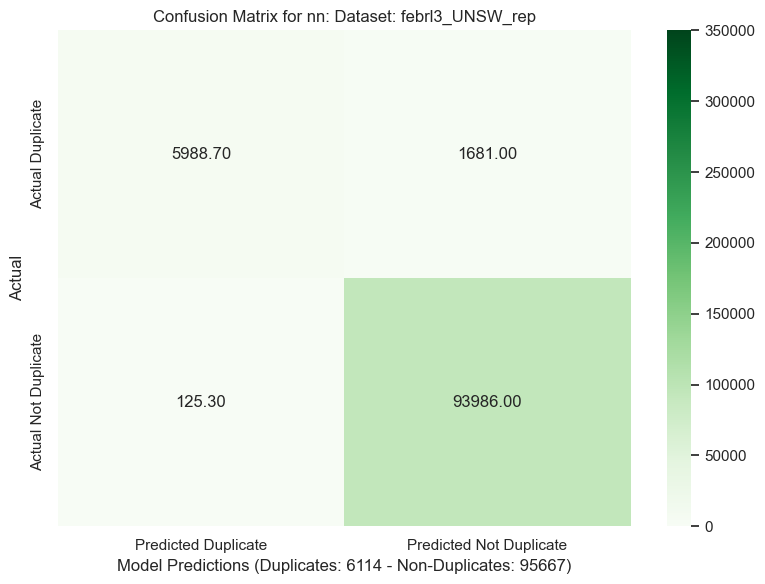

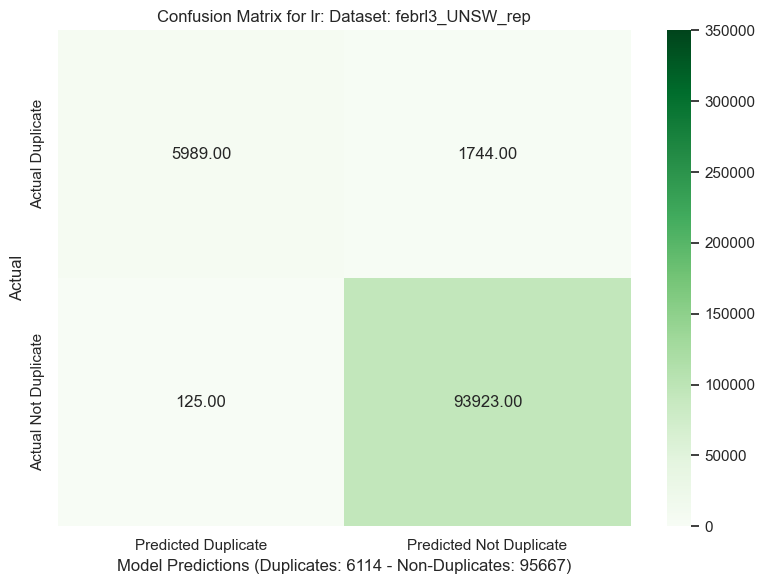

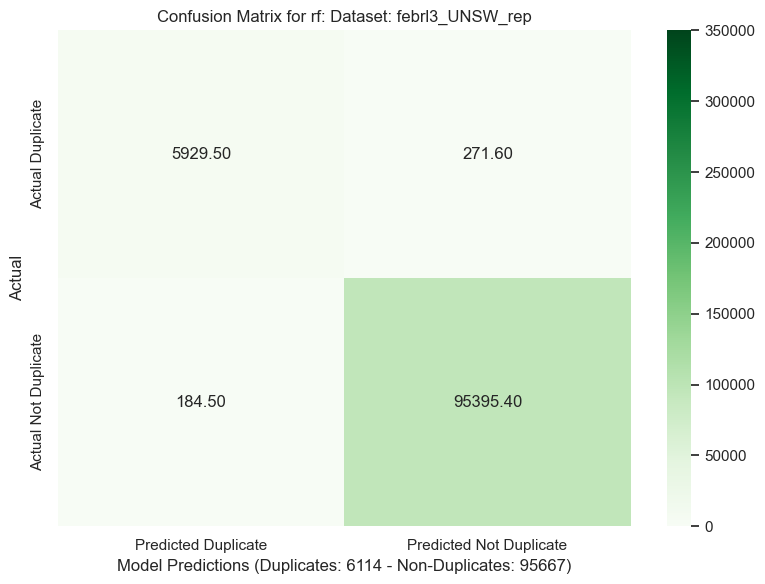

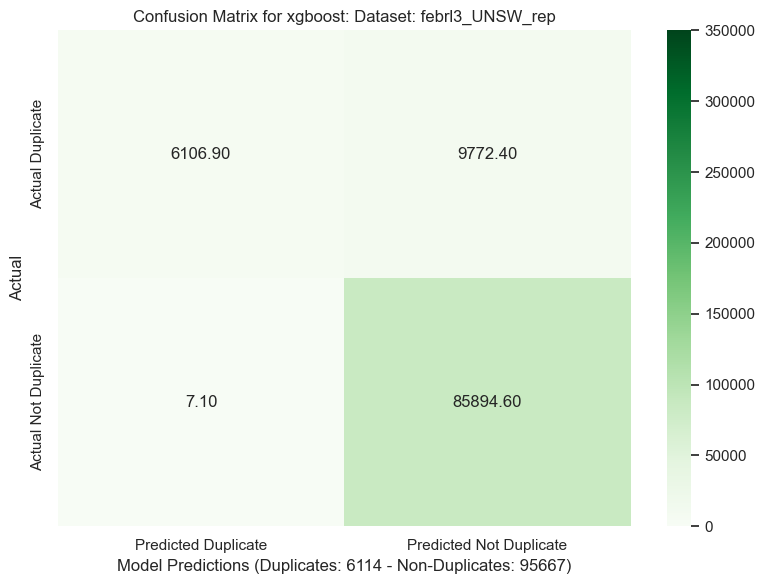

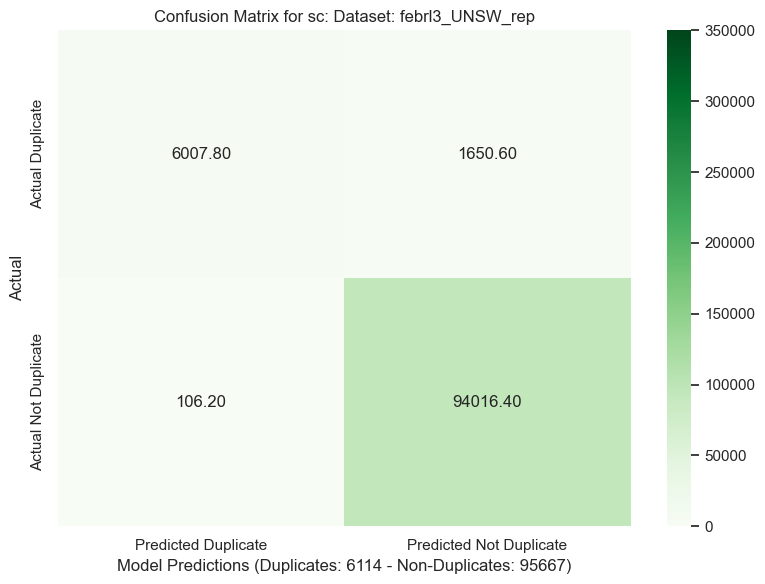

In [681]:
# Plot each confusion matrix
for model in confusion_matrix:
    cm = confusion_matrix[model]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Greens", xticklabels=["Predicted Duplicate", "Predicted Not Duplicate"], yticklabels=["Actual Duplicate", "Actual Not Duplicate"], vmin=0, vmax=350000)
    plt.xlabel(f'Model Predictions (Duplicates: {collections.Counter(y_test)[1]} - Non-Duplicates: {collections.Counter(y_test)[0]})')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model}: Dataset: {filename}')
    plt.tight_layout()
    plt.savefig(f'{filename}/confusion_matrix_{model}_{filename}.png')  # You can change the file format by changing the
    plt.show()

### Plot the AUC Score for each dataset and machine learning model

C:\Users\daneh\AppData\Local\Temp\ipykernel_58272\175854851.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Model', y='AUC', data=auc_df, marker='o', palette='viridis')


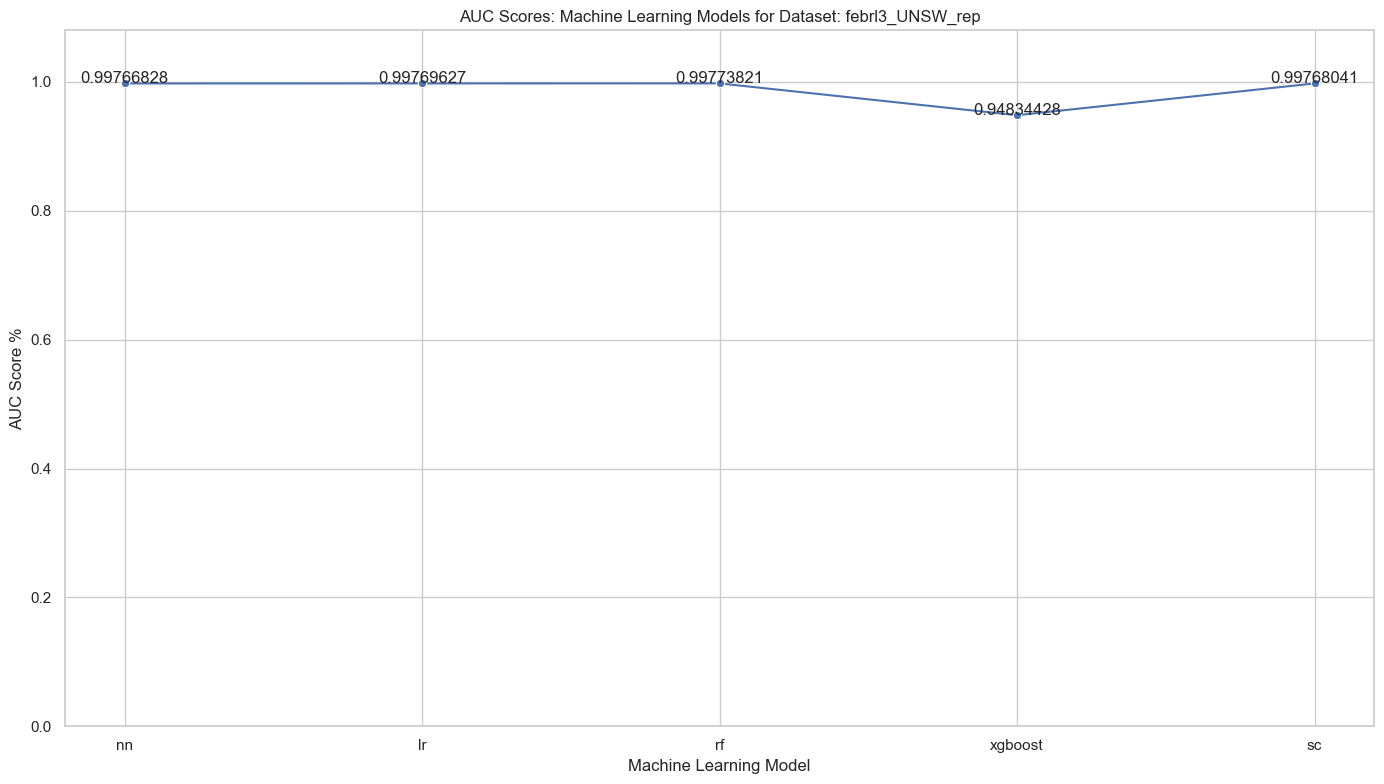

In [682]:
# Convert the dictionary to a DataFrame
auc_df = pd.DataFrame(list(auc.items()), columns=['Model', 'AUC'])

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(14, 8))
sns.lineplot(x='Model', y='AUC', data=auc_df, marker='o', palette='viridis')

# Add titles and labels
plt.title(f'AUC Scores: Machine Learning Models for Dataset: {filename}')
plt.xlabel('Machine Learning Model')
plt.ylabel('AUC Score %')

# Set y-axis limits
plt.ylim(0.0, 1.08)

# Highlight key differences
for i in range(len(auc_df)):
    plt.text(i, auc_df['AUC'][i] + 0.0000005, f"{auc_df['AUC'][i]:.8f}", ha='center')

# Save the plot to a file
plt.tight_layout()
plt.savefig('average_auc_scores_single_dataset.png')

# Show the plot
plt.savefig(f'{filename}/auc_{filename}.png')  # You can change the file format by changing the
plt.show()